### Atividade da Aula

- **Aluno:** Augusto Mathias Adams

#### Parte 1

**Rode todo o código. Responda às questões nele contidas e complete-o, se necessário**

Feito.

#### Parte 2
1. **Interprete adequadamente os resultados obtidos pela matriz de confusão.**

A Matriz de confusão apresenta como verdadeiros negativos ($TN$) o valor de 56519, para falsos positivos ($FP$) o valor de 367, para falsos negativos ($FN$) o valor de 8 e para verdadeiros positivos ($TP$) o valor de 67. Com estes dados é possível calcular outros parâmetros, tais como acurácia, precisão, recall e Escore F1, cujos valores são:

- $Acc = 100 \times \frac{TN + TP}{TN + TP + FN + FP} = 100 \times \frac{56519 + 67}{56519 + 67 + 8 + 367} = 99,34\%$
- Para $y=1$:
    - $P(\%) = 100 \times  \frac{TP}{TP+FP} = 100 \times \frac{67}{67 + 367} = 15,44\%$
    - $R(\%) = 100 \times \frac{TP}{TP+FN} = 100 \times \frac{67}{67+8} = 89,33\%$
    - $F1(\%) = 100 \times \left (2 \frac{P \times R}{P + R} \right ) = 200 \times \left (\frac{0,1544\times 0,8933}{0,1544 + 0,8933} \right) = 26,32\%$
- Para $y=0$:
    - $P(\%) = 100 \times  \frac{TN}{TN+FN} = 100 \times \frac{56519}{56519 + 8} = 99,99\%$
    - $R(\%) = 100 \times \frac{TN}{TN+FP} = 100 \times \frac{56519}{56519+367} = 99,35\%$
    - $F1(\%) = 100 \times \left (2 \frac{P \times R}{P + R} \right ) = 200 \times \left (\frac{0,9999 \times 0,9935}{0,9990 + 0,9935} \right) = 99,67\%$

O modelo apresenta alta acurácia ($98,34\%$), mas essa métrica é enganosa devido ao desbalanceamento das classes, com a classe $y=0$ predominando. Para a classe $y=1$, o *recall* é elevado ($89,33\%$), indicando que o modelo identifica a maior parte das instâncias verdadeiras dessa classe; entretanto, a precisão é baixa ($15,44\%$), refletindo um número elevado de falsos positivos. Consequentemente, o F1-Score é baixo ($26,32\%$), demonstrando dificuldade em equilibrar precisão e *recall* para essa classe.

Conclusão: o modelo está claramente desbalanceado e, embira seus parâmetros de desempenho (com ênfase no *recall* para $y=1$) permitam que o classificador treinado seja utilizado em tela, a quantidade de falsos positivo ainda é apreciável a ponto de negar muitas transações legítimas, embora seja eficaz em negar transações falsas.

2. **Descreva qual procedimento você poderia adotar visando reduzir a quantidade de falsos positivos gerados pelo modelo.**

Extraído do livro *Aurelien, Geron: Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow THIRD EDITION:* *"O **aumento de dados** aumenta artificialmente o tamanho do conjunto de treinamento ao gerar muitas variantes realistas de cada instância de treinamento. Isso reduz o **overfitting**, tornando-se uma técnica de regularização. As instâncias geradas devem ser o mais realistas possível: idealmente, dado uma imagem do conjunto de treinamento aumentado, um ser humano não deveria ser capaz de dizer se ela foi aumentada ou não. Simplesmente adicionar ruído branco não ajuda; as modificações devem ser aprendíveis (ruído branco não é)."*

...

*"O aumento de dados também é útil quando você possui um conjunto de dados desbalanceado: ele pode ser utilizado para gerar mais amostras das classes menos frequentes. Essa abordagem é chamada de técnica de superamostragem sintética de minorias, ou simplesmente **SMOTE** (**Synthetic Minority Oversampling Technique**)."*

A técnica **SMOTE** $^1$ consiste em criar dados sintéticos da classe minoritária até que o conjunto de treinamento alcance o equilíbrio, ou seja, 50\% para cada classe, no caso de classificação binária. O **SMOTE** utiliza a distância euclidiana entre os vizinhos mais próximos da classe minoritária. Os dados sintéticos são gerados ao multiplicar essa distância por um número aleatório no intervalo $[0,1]$.

Os passos do **SMOTE** podem ser descritos da seguinte forma:


- Selecionar uma instância aleatória da classe minoritária.
- Utilizar o algoritmo **KNN** para identificar os $k$ vizinhos mais próximos dessa instância. Essa etapa define a direção em que as novas observações sintéticas serão geradas.
- Calcular a distância euclidiana entre a instância selecionada e seus $k$-vizinhos.
- Multiplicar a distância obtida por um número aleatório no intervalo $[0,1]$, gerando uma nova instância sintética. Essa etapa introduz variação e diversidade no processo de geração.

O processo é repetido pelo menos $N$ vezes, onde $N$ corresponde ao número total de observações da classe minoritária, até atingir o balanceamento desejado.

A fórmula para gerar os dados sintéticos é apresentada abaixo:

$s_i = x_i + \lambda \cdot (x_{zi} - x_i)$

Onde:  

- $s_i$: nova instância sintética gerada;
- $x_i$: instância original da classe minoritária;
- $x_{zi}$: instância vizinha de $x_i$, selecionada aleatoriamente;
- $\lambda$: número aleatório entre $0$ e $1$ que controla a variação introduzida na nova instância sintética (relacionado ao passo 4).

$^1$ *Extraído de [Técnicas para Dados Desbalanceados (SMOTE e ADASYN)](https://medium.com/@balemar/t%C3%A9cnicas-para-dados-desbalanceados-smote-e-adasyn-f891f9c46c6e)*


# Classificação desbalanceada

Esse notebook é uma tradução e adaptação do exemplo apresentado [no site do Keras](https://keras.io/examples/structured_data/imbalanced_classification/), criado por [fchollet](https://twitter.com/fchollet), e que utiliza essa base de dados do Kaggle [aqui](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud).


## Introdução

Este exemplo mostra como treinar um modelo classificador quando os dados são altamente desbalanceados. O objetivo é treinar uma rede neural capaz de identificar operações financeiras fraudulentas.

## Vetorizando os dados CSV

In [18]:
import csv
import numpy as np

# Os dados reais contendo operações financeiras pode ser obtido em https://www.kaggle.com/mlg-ulb/creditcardfraud/
fname = "creditcard.csv"

todas_caracteristicas = []
todos_rotulos         = []
with open(fname) as f:
    for i, line in enumerate(f):
        if i == 0: # primeira linha da tabela: cabeçalho
            print("CABECALHO:", line.strip())
            continue  # pula cabeçalho da tabela
        fields = line.strip().split(",")
        todas_caracteristicas.append([float(v.replace('"', "")) for v in fields[:-1]])
        todos_rotulos.append([int(fields[-1].replace('"', ""))])
        if i == 1:
            print("CARACTERISTICAS:", todas_caracteristicas[-1])

caracteristicas = np.array(todas_caracteristicas, dtype="float32")
valores_alvo    = np.array(todos_rotulos, dtype="uint8")
print("caracteristicas.shape:", caracteristicas.shape)
print("valores_alvo.shape:", valores_alvo.shape)

CABECALHO: "Time","V1","V2","V3","V4","V5","V6","V7","V8","V9","V10","V11","V12","V13","V14","V15","V16","V17","V18","V19","V20","V21","V22","V23","V24","V25","V26","V27","V28","Amount","Class"
CARACTERISTICAS: [0.0, -1.3598071336738, -0.0727811733098497, 2.53634673796914, 1.37815522427443, -0.338320769942518, 0.462387777762292, 0.239598554061257, 0.0986979012610507, 0.363786969611213, 0.0907941719789316, -0.551599533260813, -0.617800855762348, -0.991389847235408, -0.311169353699879, 1.46817697209427, -0.470400525259478, 0.207971241929242, 0.0257905801985591, 0.403992960255733, 0.251412098239705, -0.018306777944153, 0.277837575558899, -0.110473910188767, 0.0669280749146731, 0.128539358273528, -0.189114843888824, 0.133558376740387, -0.0210530534538215, 149.62]
caracteristicas.shape: (284807, 30)
valores_alvo.shape: (284807, 1)


## Preparando os dados

In [19]:
num_amostras_validacao = int(len(caracteristicas) * 0.2) # deixaremos 20% dos dados para validação
X_trein = caracteristicas[:-num_amostras_validacao]
y_trein = valores_alvo[:-num_amostras_validacao]
X_val   = caracteristicas[-num_amostras_validacao:]
y_val   = valores_alvo[-num_amostras_validacao:]

print("Número de amostras de treinamento:", len(X_trein))
print("Número de amostras de validação:", len(X_val))

Número de amostras de treinamento: 227846
Número de amostras de validação: 56961


## Análise do desbalanceamento nos rótulos e atribuição de pesos diferentes

In [20]:
qtdade_amostras_cada_classe = np.bincount(y_trein[:, 0]) # função do numpy que conta a quantidade de amostras para cada classe
print(qtdade_amostras_cada_classe)
print(
    "Número de amostras positivas no conjunto de dados: {} ({:.2f}% do total)".format(
        qtdade_amostras_cada_classe[1], 100 * float(qtdade_amostras_cada_classe[1]) / len(y_trein)
    )
)

peso_classe_0 = 1.0 / qtdade_amostras_cada_classe[0]
peso_classe_1 = 1.0 / qtdade_amostras_cada_classe[1]

print("Peso para classe 0:", peso_classe_0 )
print("Peso para classe 1:", peso_classe_1 )

pesos_classes = {0: peso_classe_0, 1: peso_classe_1} # cria um dicionário com o peso de cada classe

[227429    417]
Número de amostras positivas no conjunto de dados: 417 (0.18% do total)
Peso para classe 0: 4.396976638863118e-06
Peso para classe 1: 0.002398081534772182


## Normalizando os dados usando média e desvio padrão

In [21]:
media    = np.mean(X_trein, axis=0)
X_trein -= media
X_val   -= media
desvio   = np.std(X_trein, axis=0)
X_trein /= desvio
X_val   /= desvio

## Criando uma rede neural para classificação binária

In [22]:
import keras

modelo = keras.Sequential(
    [
        keras.Input(shape=X_trein.shape[1:]),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dense(1, activation="sigmoid"),
    ]
)
modelo.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 256)               7936      
                                                                 
 dense_9 (Dense)             (None, 256)               65792     
                                                                 
 dense_10 (Dense)            (None, 256)               65792     
                                                                 
 dense_11 (Dense)            (None, 1)                 257       
                                                                 
Total params: 139777 (546.00 KB)
Trainable params: 139777 (546.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Treinando o modelo levando em conta o desbalaceamento entre as classes

In [23]:
modelo.compile(optimizer=keras.optimizers.Adam(1e-2), loss="binary_crossentropy")

modelo.fit(
    X_trein,
    y_trein,
    batch_size=2048, # define a quantidade de amostras de cada "mini-lote" (se comentarmos essa linha, será usado o padrão de 32 amostras por mini-lote)
    epochs=30,
    class_weight=pesos_classes,
)

Epoch 1/30
112/112 [==============================] - 2s 13ms/step - loss: 2.2583e-06
Epoch 2/30
112/112 [==============================] - 1s 12ms/step - loss: 1.2229e-06
Epoch 3/30
112/112 [==============================] - 1s 11ms/step - loss: 1.1453e-06
Epoch 4/30
112/112 [==============================] - 1s 11ms/step - loss: 9.7157e-07
Epoch 5/30
112/112 [==============================] - 1s 11ms/step - loss: 7.7742e-07
Epoch 6/30
112/112 [==============================] - 1s 11ms/step - loss: 7.3016e-07
Epoch 7/30
112/112 [==============================] - 1s 11ms/step - loss: 7.5873e-07
Epoch 8/30
112/112 [==============================] - 1s 11ms/step - loss: 5.4273e-07
Epoch 9/30
112/112 [==============================] - 1s 11ms/step - loss: 4.2068e-07
Epoch 10/30
112/112 [==============================] - 1s 11ms/step - loss: 4.7198e-07
Epoch 11/30
112/112 [==============================] - 1s 11ms/step - loss: 5.4075e-07
Epoch 12/30
112/112 [==============================]

In [24]:
probabilidades = modelo.predict(X_val) # cálculo da saída da rede neural para as transações de validação

print(probabilidades.shape) # verificando o shape das probabilidades

print(probabilidades[:10]) # verificando as probabilidades das primeiras 10 amostras de validação

1781/1781 [==============================] - 1s 647us/step
(56961, 1)
[[1.2672909e-22]
 [1.7450701e-12]
 [2.5073790e-17]
 [8.1769556e-02]
 [2.3324413e-02]
 [4.5613596e-10]
 [1.8405376e-06]
 [4.0953861e-18]
 [5.4951406e-06]
 [1.0901637e-20]]


In [25]:
y_val_est = (probabilidades >= 0.5).astype(int)

print(y_val_est.shape)
print(y_val_est[:10]) # mostrado a classe prevista para as primeiras 1 amostras de validação

(56961, 1)
[[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]


## Plotando matriz de confusão para os dados de validação

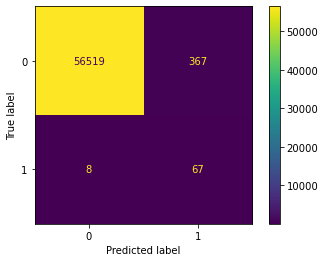

In [26]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_val, y_val_est) # cm = confusion matrix = matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()


A partir da matriz de confusão, gerada para as transações de validação, podemos perceber que (os valores abaixo podem variar ligeiramente devido à inicialização aleatória dos pesos da rede neural):

- 56961 transações de validação foram avalidadas pela rede neural
- 66 transações foram corretamente identificadas como fraudulentas
- 8 transações fraudulentas não foram detectadas
- Infelizmente, 441 transações não fraudulentas foram incorretamente classificadas como fraudulentas.


In [27]:
# calculando precisão, recall e f1 score

rotulos = ["y=0","y=1"]

tp        = np.diag(cm) # Diagonal represents true positives
precisao  = dict()
revocacao = dict()
f1_score  = dict()

for i in range(len(rotulos)):
  col = cm[:, i]
  fp = np.sum(col) - tp[i] # Sum of column minus true positive is false negative

  row = cm[i, :]
  fn = np.sum(row) - tp[i] # Sum of row minus true positive, is false negative

  valor_precisao  = tp[i] / (tp[i] + fp)
  valor_revocacao = tp[i] / (tp[i] + fn)
  valor_f1_score  = 2*valor_precisao*valor_revocacao / (valor_precisao + valor_revocacao)

  precisao[rotulos[i]] = valor_precisao
  revocacao[rotulos[i]]    = valor_revocacao
  f1_score[rotulos[i]]  = valor_f1_score

print("precisao: ", precisao)

print("recall: ", revocacao)

print("F1 score: ", f1_score)

precisao:  {'y=0': 0.9998584747111999, 'y=1': 0.1543778801843318}
recall:  {'y=0': 0.9935485005097915, 'y=1': 0.8933333333333333}
F1 score:  {'y=0': 0.9966935007450646, 'y=1': 0.2632612966601179}


Note que existe um valor de precisão, revocação e f1 score para cada classe. Nos nossos slides, tais valores foram calculados tomando-se a classe $y=1$ como referência. Entretanto, nada impede que essas 3 métricas sejam calculadas tomando-se a classe $y=0$ como referência. Imagine, por exemplo, se tivéssemos usado o rótulo $y=0$ para operações fraudulentas, e $y=1$ para operações não fraudulentas. Nesse caso, faria mais sentido observar tais métricas tomando-se o $y=0$ como referência.


Nos valores calculados observamos que, tomando os valores referentes à classe $y=1$ como referência (operações fraudulentas), o valor de precisão é relativamente baixo (mesma conclusão a qual já havíamos chegado nos nossos slides). Apesar disso, observando a matriz de confusão nós notamos que trata-se de um bom modelo para a aplicação em tela.

## Parabéns

Parabéns, você criou uma rede neural capaz de identificar operações financeiras fraudulentas.